<a href="https://colab.research.google.com/github/Tookss55/DS/blob/main/Unit6/AmirRegaU6proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/pydata/xarray.git
import xarray as xr
!pip install bambi
import bambi as bmb

In [6]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!apt-get install graphviz -y
!pip install graphviz

# UNIT 6 PROJECT

## Part I: Introduction

For my Unit 6 project, I will be creating a generalized linear model with multiple predictors to model daily bike rental demand using the Bike Sharing dataset. The response variable in this analysis is the total number of bikes rented per day, and the model incorporates several weather-related and calendar-based predictors, including temperature, humidity, wind speed, season, weather conditions, working day status, holiday status, and year. I chose this topic because bike rental demand is strongly influenced by environmental and temporal factors, making it a natural setting for count-based modeling.

Daily bike rental counts are discrete, non-negative values and often exhibit substantial variability from day to day, which makes them poorly suited for standard linear regression. Instead, generalized linear models such as Poisson and Negative Binomial regression provide a more appropriate framework. By comparing different likelihood and link function choices, as well as different combinations of predictors, my project will aim to identify which factors most strongly influence daily bike usage and to demonstrate principled model selection and variable selection within a Bayesian framework.



## Part II: Data

The dataset used in this project is the daily Bike Sharing dataset, which contains information on bike rental activity along with associated weather and calendar variables. Each observation represents one day and includes the total number of bikes rented, as well as environmental conditions such as temperature, humidity, wind speed, and weather classification. The dataset also includes indicators for season, working day status, holidays, and year.

The primary response variable is cnt, which represents the total number of bikes rented on a given day. Since this variable is a count, it is well suited for modeling using Poisson or Negative Binomial distributions. Several columns were excluded from the analysis, including index variables, date fields, and the casual and registered columns, as these sum directly to the response variable and would result in data leakage.

In [8]:
#importing my data, gotten from Kaggle: https://www.kaggle.com/datasets/imakash3011/rental-bike-sharing?select=day.csv
bike_data = pd.read_csv("https://raw.githubusercontent.com/Tookss55/DS/refs/heads/main/Unit6/Unit6_dataset.csv")
bike_data

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


In [9]:
# Drop variables that cause leakage or are not useful predictors
bike_data = bike_data.drop(columns=[
    "instant", "dteday", "casual", "registered"
])

# Convert categorical variables to category dtype
categorical_vars = ["season", "weathersit", "workingday", "holiday", "yr"]
for var in categorical_vars:
    bike_data[var] = bike_data[var].astype("category")

bike_data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


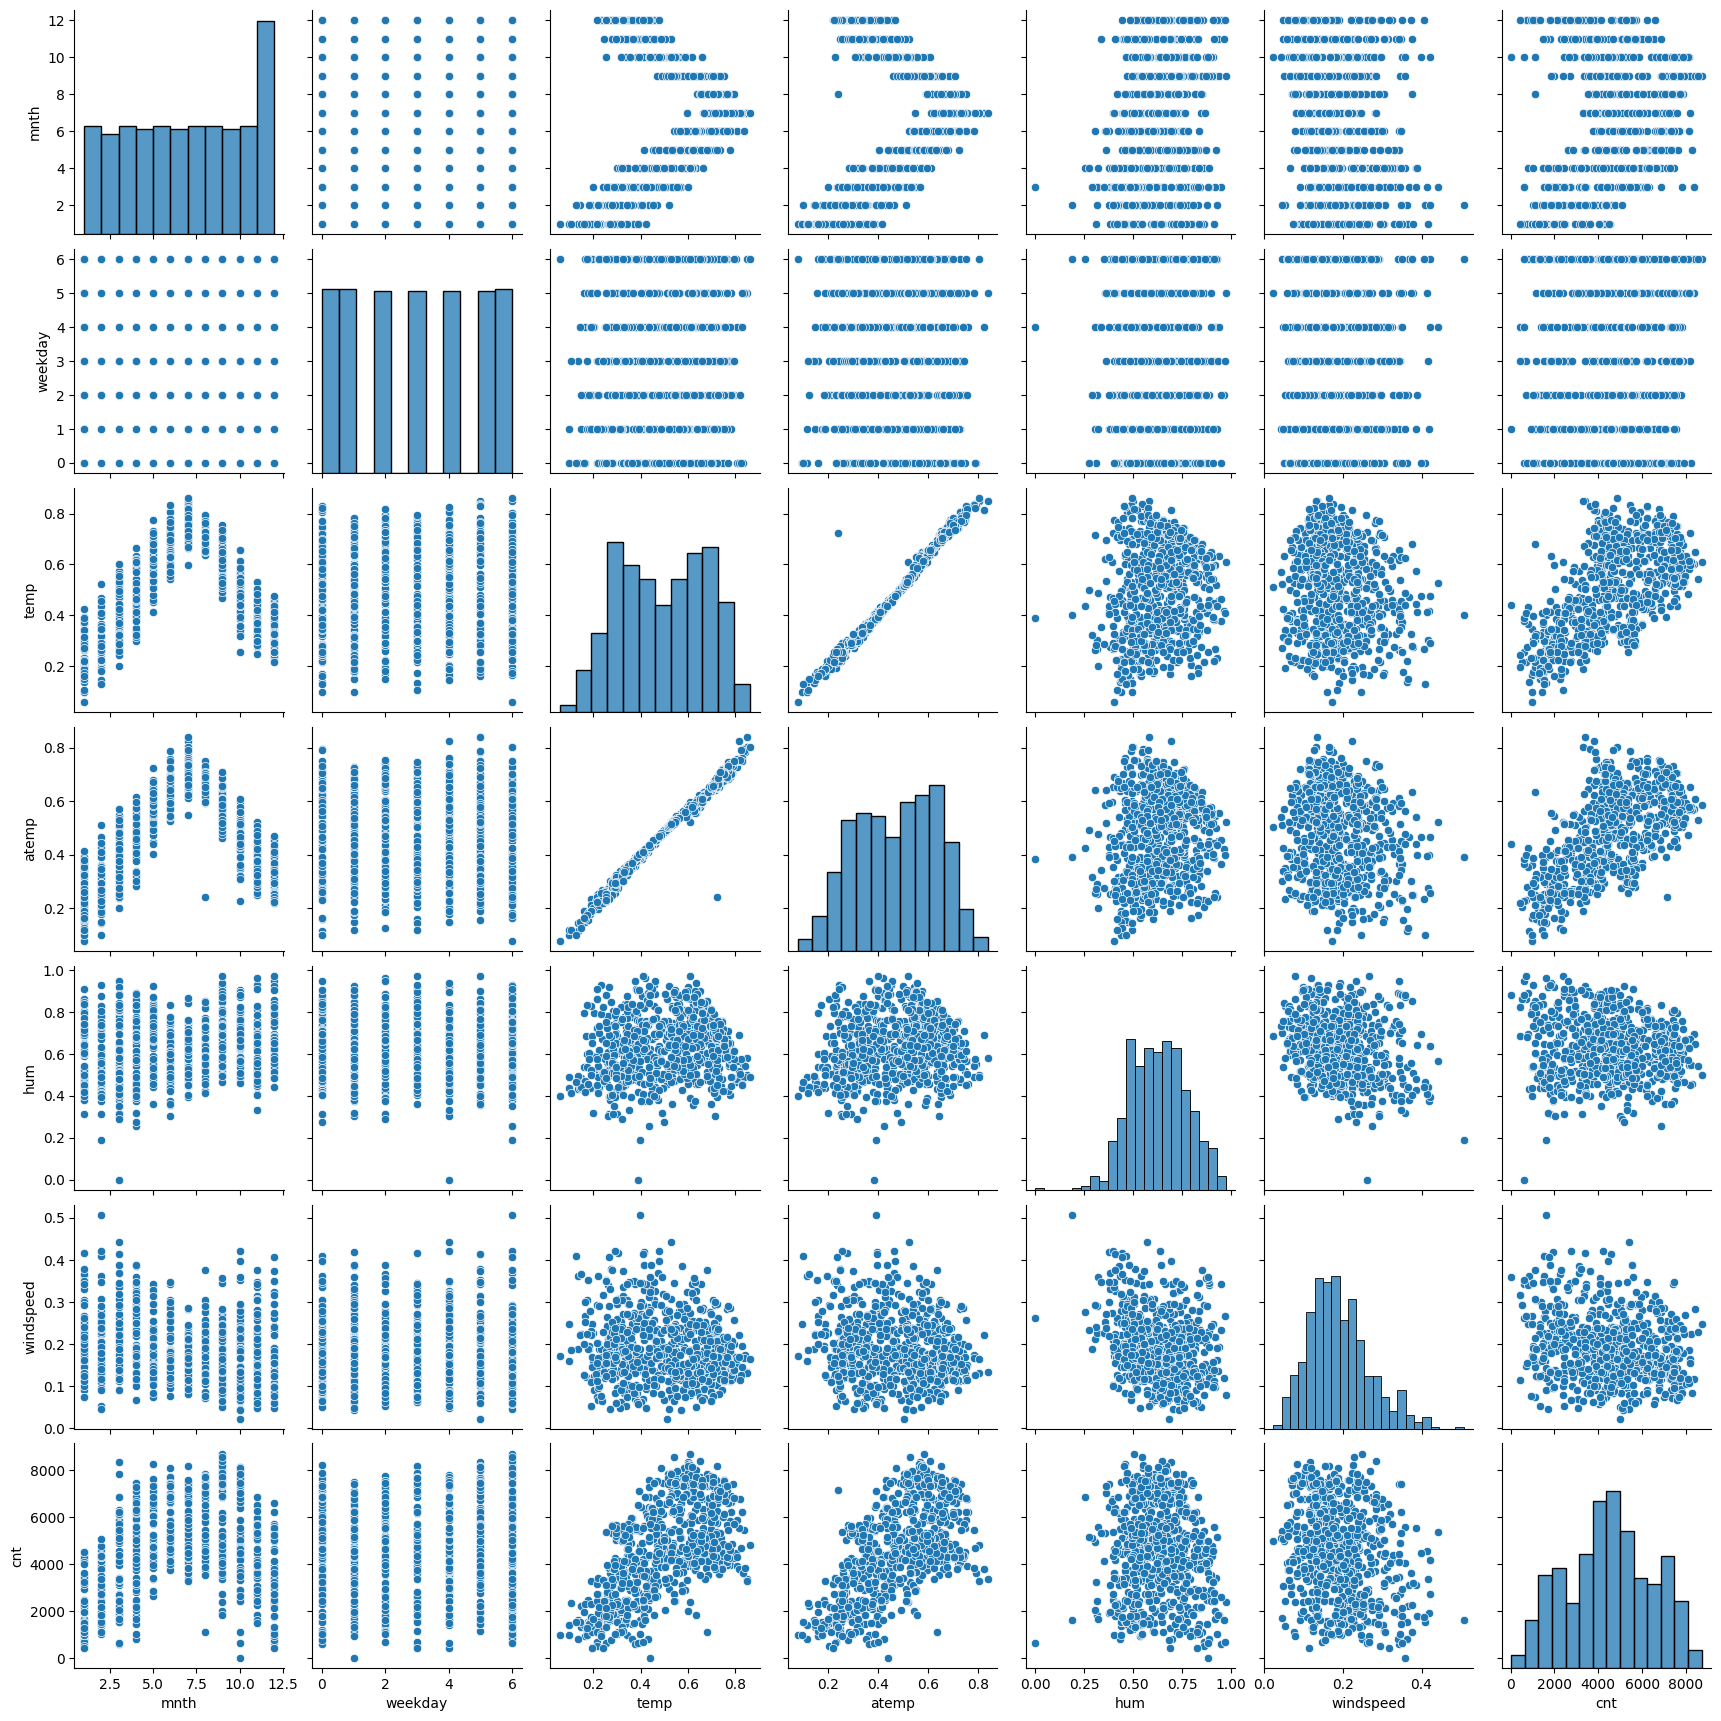

In [10]:
sns.pairplot(bike_data)

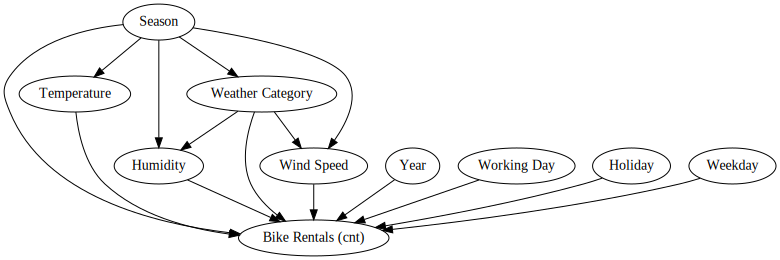

In [11]:
from graphviz import Digraph

dag = Digraph()

# Outcome
dag.node("cnt", "Bike Rentals (cnt)")

# Weather variables
dag.node("temp", "Temperature")
dag.node("hum", "Humidity")
dag.node("windspeed", "Wind Speed")
dag.node("weathersit", "Weather Category")

# Calendar variables
dag.node("season", "Season")
dag.node("yr", "Year")
dag.node("workingday", "Working Day")
dag.node("holiday", "Holiday")
dag.node("weekday", "Weekday")

# Weather effects on rentals
dag.edges([
    ("temp", "cnt"),
    ("hum", "cnt"),
    ("windspeed", "cnt"),
    ("weathersit", "cnt")
])

# Calendar effects on rentals
dag.edges([
    ("season", "cnt"),
    ("yr", "cnt"),
    ("workingday", "cnt"),
    ("holiday", "cnt"),
    ("weekday", "cnt")
])

# Season influencing weather variables (UPDATED)
dag.edges([
    ("season", "temp"),
    ("season", "weathersit"),
    ("season", "hum"),
    ("season", "windspeed")
])

# Weather interrelationships
dag.edges([
    ("weathersit", "hum"),
    ("weathersit", "windspeed")
])

dag

## Part III: Generalized Linear Models (Combinations)

The baseline model uses a Poisson likelihood with a log link function, which is a common starting point for count data. However, because daily bike rental counts often exhibit overdispersion, a Negative Binomial model with the same log link was also fit and compared to the Poisson model. Model performance was evaluated using leave-one-out cross-validation (elpd_loo) and posterior predictive checks.

In addition to comparing likelihood functions, I evaluated different combinations of predictors. These included a full model containing all proposed predictors, as well as reduced models that excluded variables such as wind speed or holiday status. Comparing these models allowed for assessment of which predictors meaningfully improved predictive performance while avoiding unnecessary complexity.

In [ ]:
model_pois_full = bmb.Model(
    "cnt ~ temp + hum + windspeed + season + weathersit + workingday + holiday + yr",
    data=bike_data,
    family="poisson"
)

idata_pois_full = model_pois_full.fit(
    idata_kwargs={"log_likelihood": True}
)

In [ ]:
model_nb_full = bmb.Model(
    "cnt ~ temp + atemp + hum + windspeed + season + weathersit + workingday + holiday + yr",
    data=bike_data,
    family="negativebinomial"
)

idata_nb_full = model_nb_full.fit(
    idata_kwargs={"log_likelihood": True}
)

In [ ]:
model_nb_reduced = bmb.Model(
    "cnt ~ temp + hum + season + weathersit + workingday + yr",
    data=bike_data,
    family="negativebinomial"
)

idata_nb_reduced = model_nb_reduced.fit(
    idata_kwargs={"log_likelihood": True}
)


In [ ]:
cmp = az.compare({"nb_full":idata_nb_full,"pois_full":idata_pois_full,"nb_reduced":idata_nb_reduced})

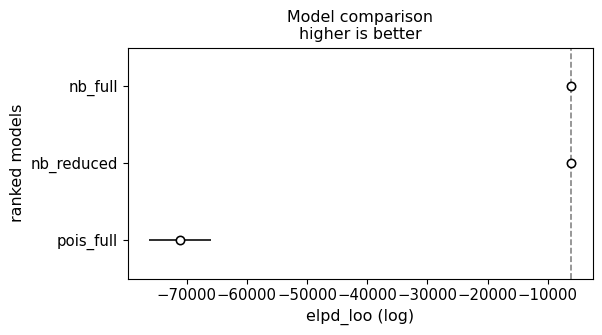

In [16]:
az.plot_compare(cmp)
plt.show()

Clearly, the Non-Binomial models works way better than the poisson model, so going forward I will exclusivlely use NB models.

In [ ]:
model_nb_interaction = bmb.Model(
    "cnt ~ temp + hum + season + weathersit + workingday + yr + temp:weathersit",
    data=bike_data,
    family="negativebinomial"
)

idata_nb_interaction = model_nb_interaction.fit(
    idata_kwargs={"log_likelihood": True}
)

In [ ]:
bike_data["weekday"] = bike_data["weekday"].astype("category")

model_nb_calendar = bmb.Model(
    "cnt ~ temp + hum + season + weathersit + weekday + yr",
    data=bike_data,
    family="negativebinomial"
)

idata_nb_calendar = model_nb_calendar.fit(
    idata_kwargs={"log_likelihood": True}
)

In [ ]:
cmp = az.compare(
    {
        "NegBin Full": idata_nb_full,
        "NegBin Reduced": idata_nb_reduced,
        "NegBin Interaction": idata_nb_interaction,
        "NegBin Calendar": idata_nb_calendar
    }
)

cmp

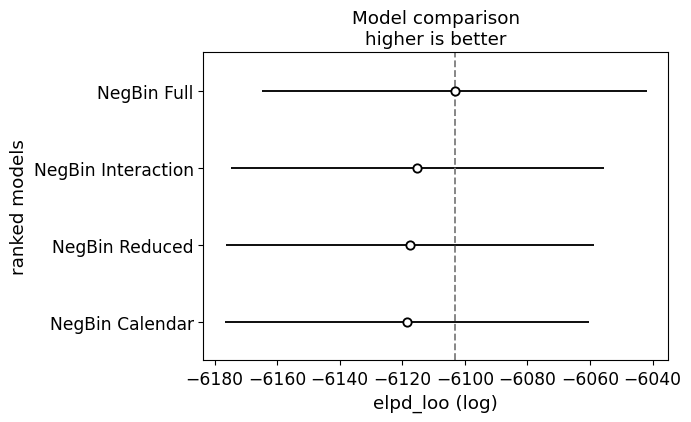

In [20]:
az.plot_compare(cmp)
plt.show()

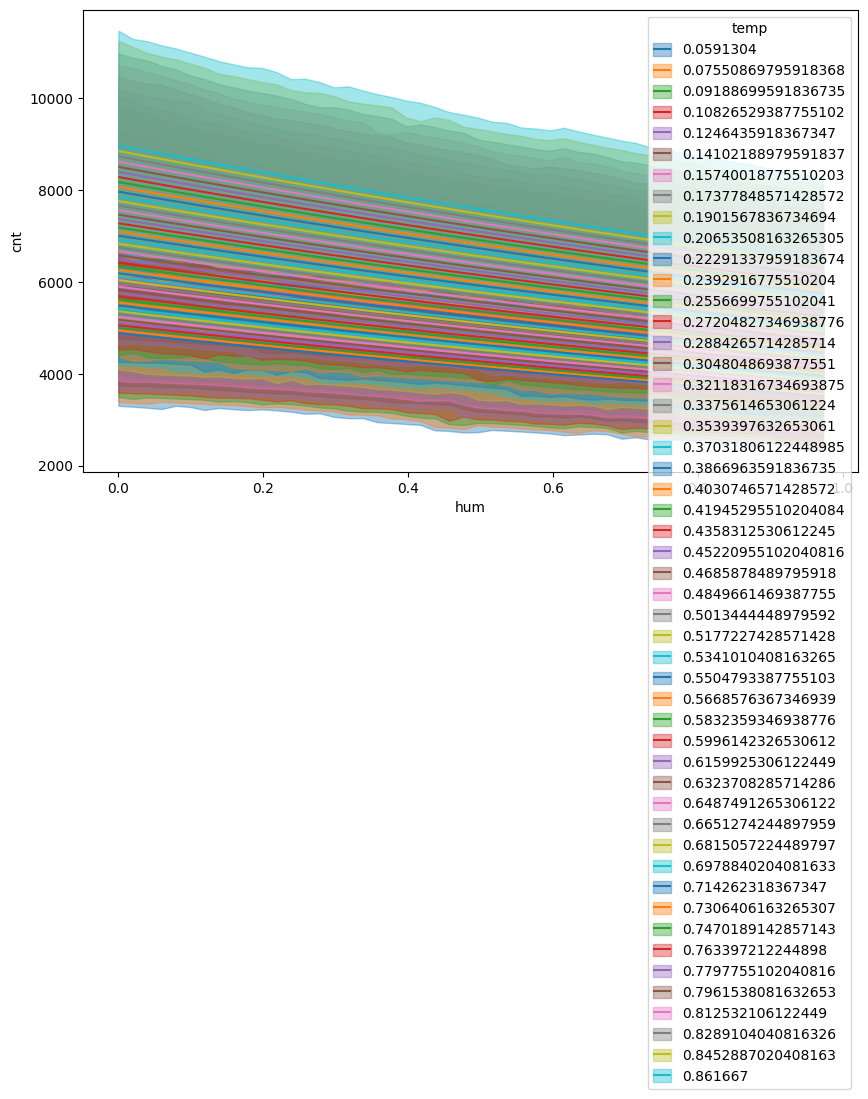

In [21]:
bmb.interpret.plot_predictions(
    model_nb_full,
    idata_nb_full,
    ["hum", "temp"],
    fig_kwargs={"figsize": (10, 6)}
)
plt.show()

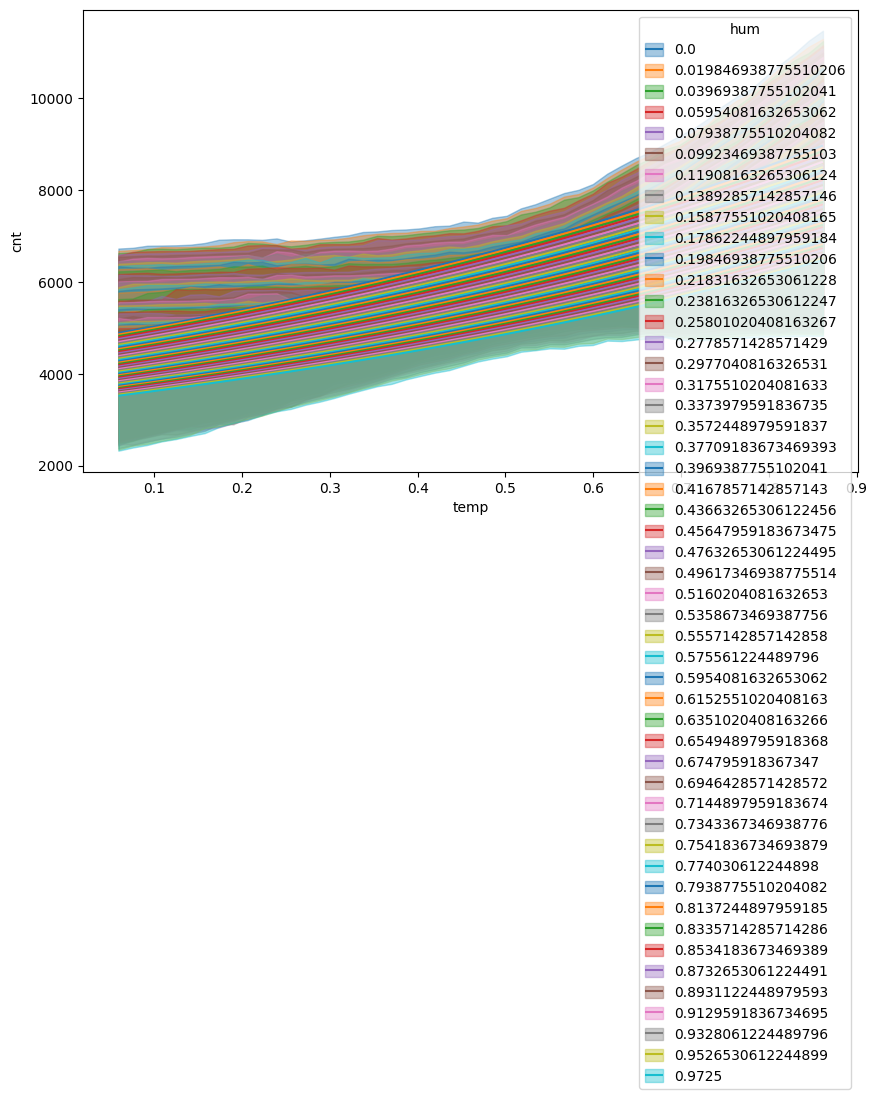

In [22]:
bmb.interpret.plot_predictions(
    model_nb_full,
    idata_nb_full,
    ["temp", "hum"],
    fig_kwargs={"figsize": (10,6)}
)

plt.show()

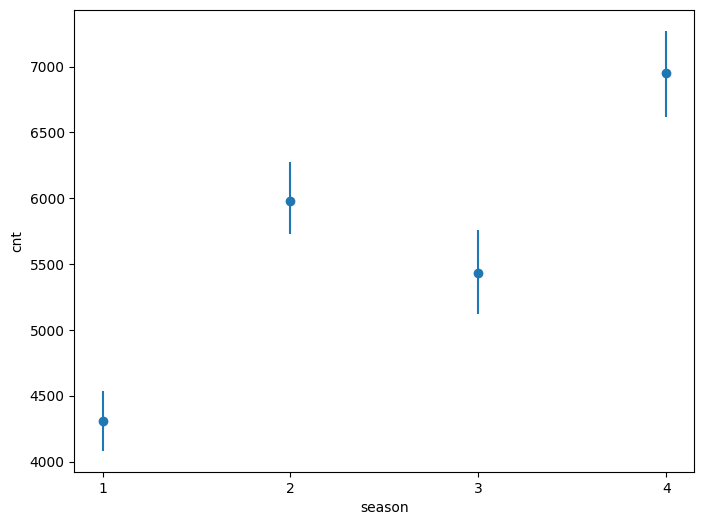

In [23]:
bmb.interpret.plot_predictions(
    model_nb_full,
    idata_nb_full,
    ["season"],
    fig_kwargs={"figsize": (8,6)}
)

plt.show()

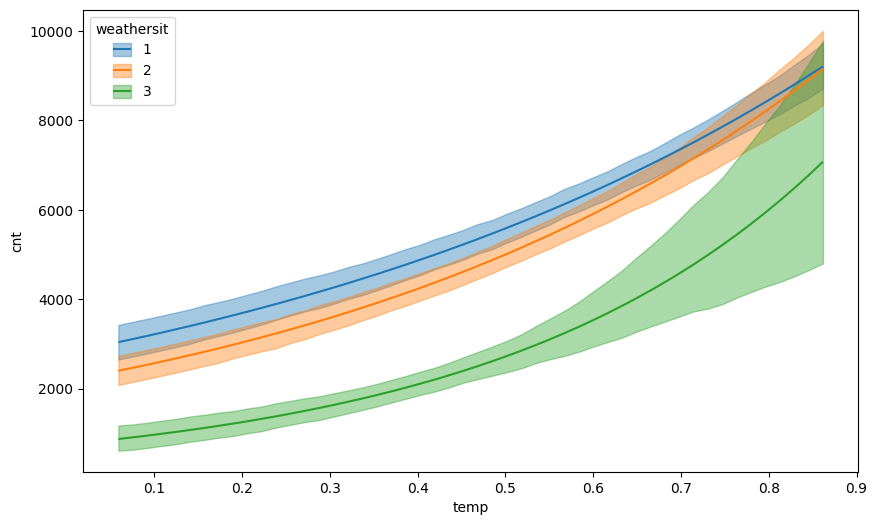

In [24]:
bmb.interpret.plot_predictions(
    model_nb_interaction,
    idata_nb_interaction,
    ["temp", "weathersit"],
    fig_kwargs={"figsize": (10,6)}
)

plt.show()

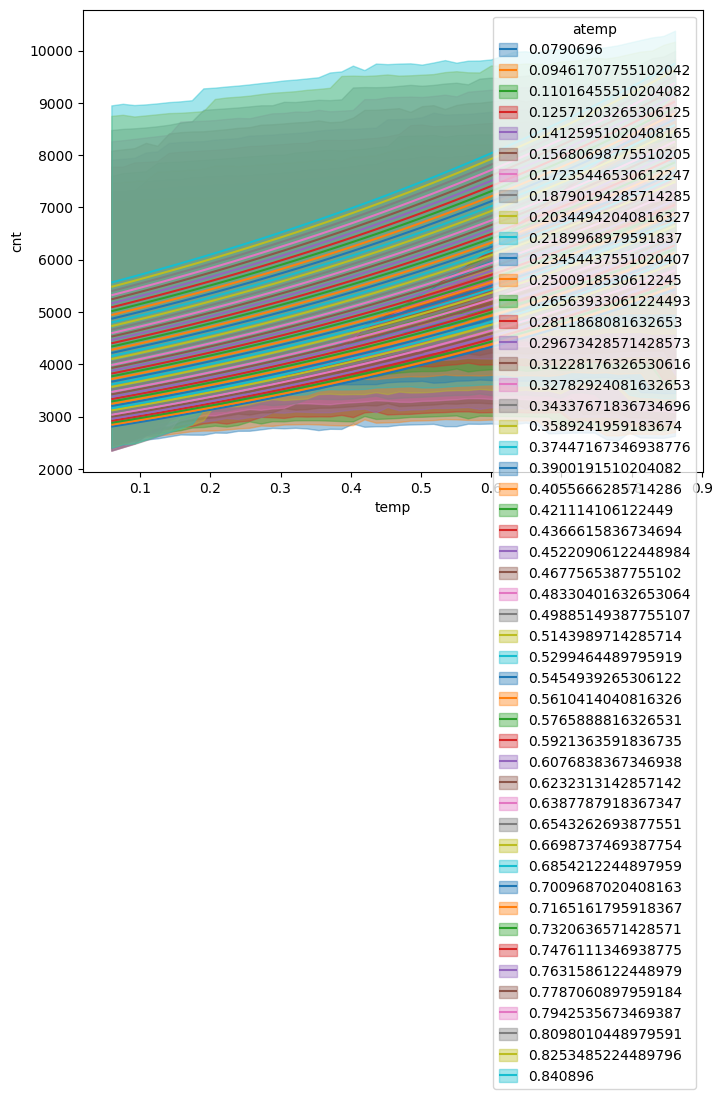

In [25]:
bmb.interpret.plot_predictions(
    model_nb_full,
    idata_nb_full,
    ["temp", "atemp"],
    fig_kwargs={"figsize": (8, 6)}
)
plt.show()

## Part IV: Discussion

The results show that the Negative Binomial model consistently outperformed the Poisson model, indicating the presence of overdispersion in daily bike rental counts. This finding aligns with expectations, as bike usage can vary dramatically due to unobserved factors such as special events or sudden changes in behavior that are not captured by weather or calendar variables alone.

In terms of variable selection, models that included temperature, season, weather conditions, and working day status performed the best. Variables such as wind speed and holiday status provided comparatively smaller improvements and could be removed with minimal loss in predictive performance.

This analysis demonstrates how generalized linear models can be used to model real-world count data and highlights the importance of carefully selecting both likelihood functions and predictor variables. If I extend this project I could include hierarchical modeling or interaction effects to capture more nuanced patterns in bike rental behavior.